In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [4]:
# Load the OD_Santander.csv and biketripsJun.csv into DataFrames
od_df = pd.read_csv("OD_Santander.csv")
bike_df = pd.read_csv("biketripsJun.csv")

## Calculate features for clustering 
Trip Duration time Calculation

In [6]:
od_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191839 entries, 0 to 191838
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ObjectID         191839 non-null  int64  
 1   Name             191839 non-null  object 
 2   StartStation Id  191839 non-null  int64  
 3   EndStation Id    191839 non-null  int64  
 4   Destinat_1       191839 non-null  int64  
 5   Total_Leng       191839 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 8.8+ MB


In [7]:
# Change the unit of the Duration field from seconds to minutes.
bike_df["Duration"] = bike_df["Duration"] / 60
bike_df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,120934794,5.0,18470,04/06/2022 10:15,30,"Windsor Terrace, Hoxton",04/06/2022 10:10,52,"Roscoe Street, St. Luke's"
1,120948759,22.0,11870,04/06/2022 16:11,157,"Wright's Lane, Kensington",04/06/2022 15:49,349,"St. George Street, Mayfair"
2,120972867,5.0,10649,05/06/2022 12:34,289,"South Audley Street, Mayfair",05/06/2022 12:29,116,"Little Argyll Street, West End"
3,120857309,14.0,11393,02/06/2022 13:19,624,"Courland Grove, Wandsworth Road",02/06/2022 13:05,624,"Courland Grove, Wandsworth Road"
4,120848312,16.0,10138,02/06/2022 09:55,624,"Courland Grove, Wandsworth Road",02/06/2022 09:39,624,"Courland Grove, Wandsworth Road"


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268459 entries, 0 to 1268458
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Rental Id          1268459 non-null  int64  
 1   Duration           1268459 non-null  float64
 2   Bike Id            1268459 non-null  int64  
 3   End Date           1268459 non-null  object 
 4   EndStation Id      1268459 non-null  int64  
 5   EndStation Name    1268459 non-null  object 
 6   Start Date         1268459 non-null  object 
 7   StartStation Id    1268459 non-null  int64  
 8   StartStation Name  1268459 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 87.1+ MB


In [6]:
# Perform an inner join based on "StartStation Id" and "EndStation Id"
# short_distanceOD = pd.merge(bike_df, od_df, left_on=["StartStation Id", "EndStation Id"], right_on=["StartStation Id", "EndStation Id"], how="inner")

# Save the joined DataFrame to a new CSV file
#result_df.to_csv("OD_biketrips.csv", index=False)

#print("Join completed and saved to joined_biketrips.csv.")

In [8]:
# Merge bike_df with od_df using a left join, matching based on EndStation Id and StartStation Id
merged_df = bike_df.merge(od_df, how='left', left_on=['EndStation Id', 'StartStation Id'], right_on=['EndStation Id', 'StartStation Id'])


In [9]:
# 删除值为0或缺失的行
merged_df = merged_df[(merged_df['Total_Leng'] != 0) & (~merged_df['Total_Leng'].isnull())]


In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311468 entries, 5 to 1268458
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Rental Id          311468 non-null  int64  
 1   Duration           311468 non-null  float64
 2   Bike Id            311468 non-null  int64  
 3   End Date           311468 non-null  object 
 4   EndStation Id      311468 non-null  int64  
 5   EndStation Name    311468 non-null  object 
 6   Start Date         311468 non-null  object 
 7   StartStation Id    311468 non-null  int64  
 8   StartStation Name  311468 non-null  object 
 9   ObjectID           311468 non-null  float64
 10  Name               311468 non-null  object 
 11  Destinat_1         311468 non-null  float64
 12  Total_Leng         311468 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 33.3+ MB


In [10]:
short_distanceOD = merged_df
short_distanceOD.describe()

,Rental Id,Duration,Bike Id,EndStation Id,StartStation Id,ObjectID,Destinat_1,Total_Leng
count,3.114680e+05,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000
mean,1.214624e+08,20.847988,15805.017218,419.782620,423.517841,93197.403968,211.257991,13298.697542
std,3.750700e+05,62.893510,5937.057686,224.189694,223.714900,55742.009695,128.584547,8692.620168
min,1.208044e+08,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.001502
25%,1.211409e+08,8.000000,12050.000000,225.000000,227.000000,43503.500000,97.000000,5741.259380
50%,1.214631e+08,14.000000,17600.000000,430.000000,431.000000,88968.000000,210.000000,12244.936720
75%,1.217883e+08,22.000000,20589.000000,619.000000,622.000000,142525.000000,321.000000,19327.944252
max,1.221083e+08,7334.000000,23053.000000,788.000000,789.000000,191839.000000,437.000000,40327.300860


In [11]:
short_distanceOD.rename(columns={'Total_Leng': 'Shortest_Distance'}, inplace=True)
short_distanceOD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311468 entries, 5 to 1268458
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Rental Id          311468 non-null  int64  
 1   Duration           311468 non-null  float64
 2   Bike Id            311468 non-null  int64  
 3   End Date           311468 non-null  object 
 4   EndStation Id      311468 non-null  int64  
 5   EndStation Name    311468 non-null  object 
 6   Start Date         311468 non-null  object 
 7   StartStation Id    311468 non-null  int64  
 8   StartStation Name  311468 non-null  object 
 9   ObjectID           311468 non-null  float64
 10  Name               311468 non-null  object 
 11  Destinat_1         311468 non-null  float64
 12  Shortest_Distance  311468 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 33.3+ MB


### calculate ideal trip duration (shortest path / avererage speed )
Shortest Distance between each group of each Santander dock base station has been calculated in ArcGIS network analysis section.
Assume that trips under shortest distance between origin and destination are travelling at 20 mph, which is the cycling speed limit of London core area.

Then Calculate the value of the IdealTime.

**IdealTime:** Ideal fastest ride time for each leg of the journey according to the shortest route(minutes)<br> 
IdealTime = <u>Shortest_Distance (meters) / (AvgSpeed (mph)/ 0.0372822724577)</u>
<br> <br>Then Converting "mph" to "meters per minute"(1 mph = 0.0372822724577 meters per minute)

In [12]:
short_distanceOD['AvgSpeed'] = 20

short_distanceOD['IdealTime'] = short_distanceOD['Shortest_Distance'] / (short_distanceOD['AvgSpeed'] / 0.0372822724577) 

short_distanceOD.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,ObjectID,Name,Destinat_1,Shortest_Distance,AvgSpeed,IdealTime
5,121057618,6.0,20730,07/06/2022 16:20,581,"New Cavendish Street, Marylebone",07/06/2022 16:14,364,"Store Street, Bloomsbury",69349.0,"Marloes Road, Kensington - Location 581",185.0,10138.211320,20,18.898778
10,120930398,13.0,7444,03/06/2022 23:46,361,"Waterloo Station 2, Waterloo",03/06/2022 23:33,383,"Frith Street, Soho",73282.0,"Palace Gate, Kensington Gardens - Location 361",174.0,5340.003407,20,9.954373
20,120855210,21.0,22076,02/06/2022 12:45,71,"Newgate Street , St. Paul's",02/06/2022 12:24,400,"George Street, Marylebone",77993.0,"Wren Street, Holborn - Location 71",35.0,2122.067881,20,3.955776
21,120881968,9.0,16080,02/06/2022 19:53,153,"Bayswater Road, Hyde Park",02/06/2022 19:44,400,"George Street, Marylebone",78216.0,"Wren Street, Holborn - Location 153",258.0,16309.166700,20,30.402140
22,121020068,16.0,20252,06/06/2022 18:09,752,"London Street, Paddington",06/06/2022 17:53,400,"George Street, Marylebone",78145.0,"Wren Street, Holborn - Location 752",187.0,12452.037530,20,23.212013


In [13]:
short_distanceOD.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,ObjectID,Name,Destinat_1,Shortest_Distance,AvgSpeed,IdealTime
5,121057618,6.0,20730,07/06/2022 16:20,581,"New Cavendish Street, Marylebone",07/06/2022 16:14,364,"Store Street, Bloomsbury",69349.0,"Marloes Road, Kensington - Location 581",185.0,10138.211320,20,18.898778
10,120930398,13.0,7444,03/06/2022 23:46,361,"Waterloo Station 2, Waterloo",03/06/2022 23:33,383,"Frith Street, Soho",73282.0,"Palace Gate, Kensington Gardens - Location 361",174.0,5340.003407,20,9.954373
20,120855210,21.0,22076,02/06/2022 12:45,71,"Newgate Street , St. Paul's",02/06/2022 12:24,400,"George Street, Marylebone",77993.0,"Wren Street, Holborn - Location 71",35.0,2122.067881,20,3.955776
21,120881968,9.0,16080,02/06/2022 19:53,153,"Bayswater Road, Hyde Park",02/06/2022 19:44,400,"George Street, Marylebone",78216.0,"Wren Street, Holborn - Location 153",258.0,16309.166700,20,30.402140
22,121020068,16.0,20252,06/06/2022 18:09,752,"London Street, Paddington",06/06/2022 17:53,400,"George Street, Marylebone",78145.0,"Wren Street, Holborn - Location 752",187.0,12452.037530,20,23.212013


In [13]:
# 将列名从 'Duration' 改为 'ActualDuration'
short_distanceOD.rename(columns={'Duration': 'Actual Duration'}, inplace=True)

# 将列名从 'IdealTime' 改为 'IdealDuration'
short_distanceOD.rename(columns={'IdealTime': 'Ideal Duration'}, inplace=True)

short_distanceOD['Duration Gap'] = short_distanceOD['Ideal Duration'] - short_distanceOD['Actual Duration'] 
short_distanceOD['RoamingToShortestDistanceRatio'] = short_distanceOD['Ideal Duration'] / short_distanceOD['Actual Duration'] 

short_distanceOD.head()

,Rental Id,Actual Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,ObjectID,Name,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio
5,121057618,6.0,20730,07/06/2022 16:20,581,"New Cavendish Street, Marylebone",07/06/2022 16:14,364,"Store Street, Bloomsbury",69349.0,"Marloes Road, Kensington - Location 581",185.0,10138.211320,20,18.898778,12.898778,3.149796
10,120930398,13.0,7444,03/06/2022 23:46,361,"Waterloo Station 2, Waterloo",03/06/2022 23:33,383,"Frith Street, Soho",73282.0,"Palace Gate, Kensington Gardens - Location 361",174.0,5340.003407,20,9.954373,-3.045627,0.765721
20,120855210,21.0,22076,02/06/2022 12:45,71,"Newgate Street , St. Paul's",02/06/2022 12:24,400,"George Street, Marylebone",77993.0,"Wren Street, Holborn - Location 71",35.0,2122.067881,20,3.955776,-17.044224,0.188370
21,120881968,9.0,16080,02/06/2022 19:53,153,"Bayswater Road, Hyde Park",02/06/2022 19:44,400,"George Street, Marylebone",78216.0,"Wren Street, Holborn - Location 153",258.0,16309.166700,20,30.402140,21.402140,3.378016
22,121020068,16.0,20252,06/06/2022 18:09,752,"London Street, Paddington",06/06/2022 17:53,400,"George Street, Marylebone",78145.0,"Wren Street, Holborn - Location 752",187.0,12452.037530,20,23.212013,7.212013,1.450751


In [15]:
#short_distanceOD.to_csv('ODtrips_calculated.csv', index=False)

In [16]:
data = short_distanceOD
data.describe()

,Rental Id,Actual Duration,Bike Id,EndStation Id,StartStation Id,ObjectID,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio
count,3.114680e+05,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.0,311468.000000,311468.000000,3.114680e+05
mean,1.214624e+08,20.847988,15805.017218,419.782620,423.517841,93197.403968,211.257991,13298.697542,20.0,24.790283,3.942296,2.394555e+00
std,3.750700e+05,62.893510,5937.057686,224.189694,223.714900,55742.009695,128.584547,8692.620168,0.0,16.204032,64.947796,3.143697e+00
min,1.208044e+08,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.001502,20.0,0.000003,-7285.808658,3.779416e-09
25%,1.211409e+08,8.000000,12050.000000,225.000000,227.000000,43503.500000,97.000000,5741.259380,20.0,10.702360,-5.586139,6.554153e-01
50%,1.214631e+08,14.000000,17600.000000,430.000000,431.000000,88968.000000,210.000000,12244.936720,20.0,22.825953,6.089652,1.462939e+00
75%,1.217883e+08,22.000000,20589.000000,619.000000,622.000000,142525.000000,321.000000,19327.944252,20.0,36.029484,21.581648,2.959736e+00
max,1.221083e+08,7334.000000,23053.000000,788.000000,789.000000,191839.000000,437.000000,40327.300860,20.0,75.174671,67.685129,6.281888e+01


We can observe that the maximum value of 'Actual Duration (minutes)' is 7334, which appears to be an outlier compared to the rest of the data. In contrast, 75% of the data points have an 'Actual Duration' of 22 minutes or less, which aligns with our common sense expectations for bike rental durations. To ensure the reliability of our analysis, we will proceed with the following steps to identify and remove outliers from the dataset.

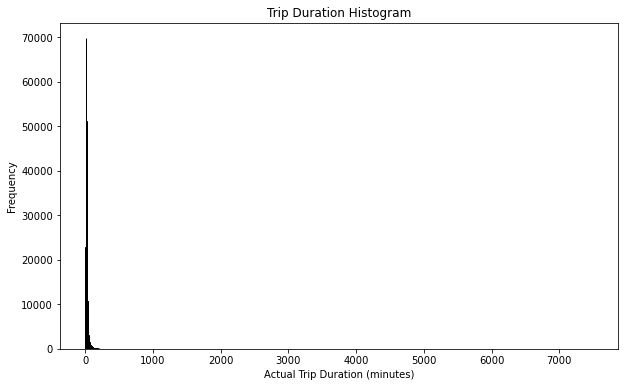

In [17]:
# Plot a histogram of trip durations in minutes
plt.figure(figsize=(10, 6))
plt.hist(data['Actual Duration'], bins=np.arange(0, 7500, 5), color='skyblue', edgecolor='black')
plt.title('Trip Duration Histogram')
plt.xlabel('Actual Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

### Data Cleaning

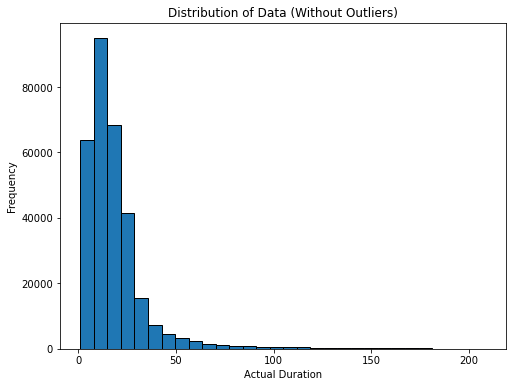

Number of outliers removed: 1186
Outliers:          Rental Id  Actual Duration  Bike Id          End Date  EndStation Id  \
24609    121041281            367.0    10909  07/06/2022 14:25            215   
30464    120804773            560.0    11352  01/06/2022 10:17            345   
51764    120848184            228.0    16738  02/06/2022 13:22            395   
60530    121059698            301.0    19406  07/06/2022 22:01            131   
70179    121050232            295.0     2065  07/06/2022 17:08            158   
...            ...              ...      ...               ...            ...   
1248577  122075641            392.0     2044  30/06/2022 15:36            638   
1254339  122067721            663.0     2533  30/06/2022 17:41            363   
1261574  122087980            241.0     3729  30/06/2022 19:22            349   
1261585  122087977            241.0    17433  30/06/2022 19:22            349   
1261586  122088002            241.0     1972  30/06/2022 19:22    

In [18]:
#  Calculate summary statistics
mean_value = data['Actual Duration'].mean()
std_dev = data['Actual Duration'].std()

'''
# Define a threshold for outliers
# Commonly used threshold is mean +/- 3 * standard deviation
lower_bound = mean_value - 3 * std_dev
upper_bound = mean_value + 3 * std_dev

# Identify and remove outliers
outliers = data[(data['Actual Duration'] < lower_bound) | (data['Actual Duration'] > upper_bound)]
data_no_outliers = data[(data['Actual Duration'] >= lower_bound) & (data['Actual Duration'] <= upper_bound)]
'''


# Visualize the data without outliers
plt.figure(figsize=(8, 6))
plt.hist(data_no_outliers['Actual Duration'], bins=30, edgecolor='k')
plt.title('Distribution of Data (Without Outliers)')
plt.xlabel('Actual Duration')
plt.ylabel('Frequency')
plt.show()

# Optional: Print information about removed outliers
print("Number of outliers removed:", len(outliers))
print("Outliers:", outliers)

In [19]:
#data_no_outliers.to_excel('data_no_outliers.xlsx', index=True)
data_no_outliers.describe()

,Rental Id,Actual Duration,Bike Id,EndStation Id,StartStation Id,ObjectID,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio
count,3.102820e+05,310282.000000,310282.000000,310282.000000,310282.000000,310282.000000,310282.000000,310282.000000,310282.0,310282.000000,310282.000000,3.102820e+05
mean,1.214625e+08,18.587536,15808.418542,419.639815,423.426203,93176.092258,211.305296,13302.634284,20.0,24.797622,6.210085,2.403467e+00
std,3.750936e+05,18.582666,5935.107483,224.166830,223.736439,55743.867167,128.551425,8691.908976,0.0,16.202706,24.622655,3.146384e+00
min,1.208044e+08,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.001502,20.0,0.000003,-208.107820,1.564552e-08
25%,1.211410e+08,8.000000,12055.000000,225.000000,227.000000,43468.000000,97.000000,5745.720826,20.0,10.710676,-5.432878,6.629339e-01
50%,1.214632e+08,14.000000,17602.000000,430.000000,431.000000,88942.000000,210.000000,12254.321160,20.0,22.843447,6.195737,1.470503e+00
75%,1.217885e+08,22.000000,20590.000000,619.000000,622.000000,142501.000000,321.000000,19334.099780,20.0,36.040959,21.645010,2.969038e+00
max,1.221083e+08,209.000000,23053.000000,788.000000,789.000000,191839.000000,437.000000,40327.300860,20.0,75.174671,67.685129,6.281888e+01


## K-Means Clustering

In [21]:
# 选择聚类所需的列
# 'SD'列代表Shortest Distance，'RD'列代表Roaming Distance
#data_for_clustering = data_no_outliers[['Ideal Duration', 'Actual Duration', 'Duration Gap','Shortest_Distance']]
data_for_clustering = data_no_outliers[['Actual Duration','Duration Gap','Shortest_Distance']]
#data_for_clustering = data_no_outliers[['Actual Duration','Duration Gap']]
data_for_clustering.describe()

,Actual Duration,Duration Gap,Shortest_Distance
count,310282.000000,310282.000000,310282.000000
mean,18.587536,6.210085,13302.634284
std,18.582666,24.622655,8691.908976
min,1.000000,-208.107820,0.001502
25%,8.000000,-5.432878,5745.720826
50%,14.000000,6.195737,12254.321160
75%,22.000000,21.645010,19334.099780
max,209.000000,67.685129,40327.300860


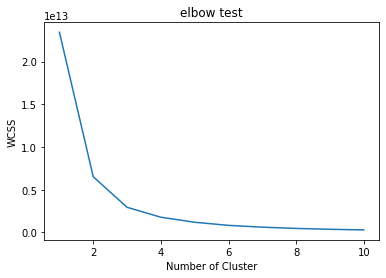

In [22]:
# elbow test to find best cluster amount
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('elbow test')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')  # 聚类内误差平方和 Within-Cluster-Sum-of-Squares
plt.show()

In [22]:
# Checking and preparing data_for_clustering
data_for_clustering = data_no_outliers[['Actual Duration','Duration Gap','Shortest_Distance']].copy()

# Convert to numeric and handle missing values
data_for_clustering = data_for_clustering.apply(pd.to_numeric, errors='coerce')
data_for_clustering.dropna(inplace=True)

# Perform KMeans clustering
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
data_no_outliers['cluster'] = kmeans.fit_predict(data_for_clustering)

# Analyze clusters
cluster_0 = data_no_outliers[data_no_outliers['cluster'] == 0]
cluster_1 = data_no_outliers[data_no_outliers['cluster'] == 1]
#cluster_2 = data_no_outliers[data_no_outliers['cluster'] == 2]

# Print statistical data for each cluster
print("Statistics for Cluster 0:")
print(cluster_0.describe())
print("\n\nStatistics for Cluster 1")
print(cluster_1.describe())

# Display first few rows of data_no_outliers
data_no_outliers.head()

/tmp/ipykernel_1431/1961412587.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['cluster'] = kmeans.fit_predict(data_for_clustering)


Statistics for Cluster 0:
          Rental Id  Actual Duration        Bike Id  EndStation Id  \
count  1.343110e+05    134311.000000  134311.000000  134311.000000   
mean   1.214617e+08        18.804960   15800.456389     407.293818   
std    3.754128e+05        18.556186    5943.882567     220.832177   
min    1.208044e+08         1.000000       1.000000       1.000000   
25%    1.211395e+08         9.000000   12018.000000     207.000000   
50%    1.214637e+08        14.000000   17590.000000     427.000000   
75%    1.217889e+08        23.000000   20596.000000     586.000000   
max    1.221083e+08       209.000000   23053.000000     788.000000   

       StartStation Id       ObjectID     Destinat_1  Shortest_Distance  \
count    134311.000000  134311.000000  134311.000000      134311.000000   
mean        410.094832   89812.833491     330.583094       21754.816853   
std         221.272492   54869.747521      69.474438        5428.732936   
min           1.000000     238.000000     1

,Rental Id,Actual Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,ObjectID,Name,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio,cluster
5,121057618,6.0,20730,07/06/2022 16:20,581,"New Cavendish Street, Marylebone",07/06/2022 16:14,364,"Store Street, Bloomsbury",69349.0,"Marloes Road, Kensington - Location 581",185.0,10138.211320,20,18.898778,12.898778,3.149796,1
10,120930398,13.0,7444,03/06/2022 23:46,361,"Waterloo Station 2, Waterloo",03/06/2022 23:33,383,"Frith Street, Soho",73282.0,"Palace Gate, Kensington Gardens - Location 361",174.0,5340.003407,20,9.954373,-3.045627,0.765721,1
20,120855210,21.0,22076,02/06/2022 12:45,71,"Newgate Street , St. Paul's",02/06/2022 12:24,400,"George Street, Marylebone",77993.0,"Wren Street, Holborn - Location 71",35.0,2122.067881,20,3.955776,-17.044224,0.188370,1
21,120881968,9.0,16080,02/06/2022 19:53,153,"Bayswater Road, Hyde Park",02/06/2022 19:44,400,"George Street, Marylebone",78216.0,"Wren Street, Holborn - Location 153",258.0,16309.166700,20,30.402140,21.402140,3.378016,0
22,121020068,16.0,20252,06/06/2022 18:09,752,"London Street, Paddington",06/06/2022 17:53,400,"George Street, Marylebone",78145.0,"Wren Street, Holborn - Location 752",187.0,12452.037530,20,23.212013,7.212013,1.450751,1


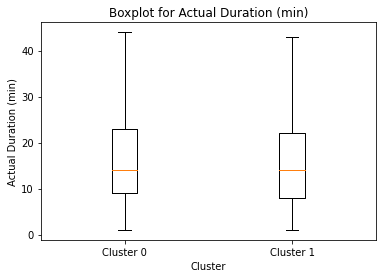

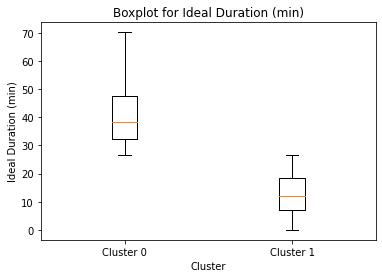

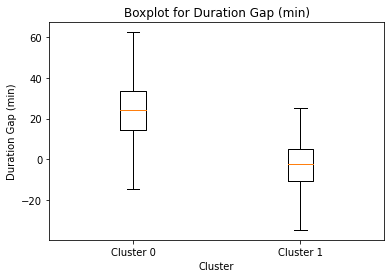

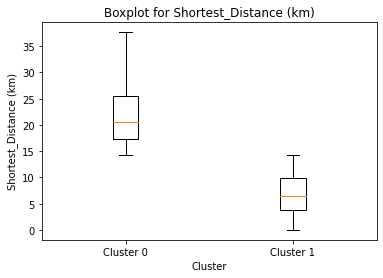

In [23]:
# Create a list of dataframes
dataframes = [cluster_0, cluster_1]

# List of variable names to compare
variables = ["Actual Duration", "Ideal Duration", "Duration Gap", "Shortest_Distance"]

# 定义每个变量的单位
units = {
    "Actual Duration": "min",
    "Ideal Duration": "min",
    "Duration Gap": "min",
    "Shortest_Distance": "km",  # 单位改为千米
    "capacity": ""
}

# 循环遍历每个变量并创建boxplots
for var in variables:
    # 为当前变量创建一个列表来存储数据
    # 如果变量是'Shortest_Distance'，则将数据从米转换为千米
    if var == "Shortest_Distance":
        data_no_outliers = [df[var] / 1000 for df in dataframes]  # 转换为千米
    else:
        data_no_outliers = [df[var] for df in dataframes]
    
    # 创建一个图形和坐标轴
    fig, ax = plt.subplots()
    
    # 创建一个不显示异常值的boxplot
    ax.boxplot(data_no_outliers, labels=["Cluster 0", "Cluster 1"], showfliers=False)
    
    # 设置标题和标签
    unit = units[var]  # 获取当前变量的单位
    ax.set_title(f"Boxplot for {var} ({unit})")  # 标题中包括单位
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"{var} ({unit})")  # y轴标签也可以包括单位
    
    # 显示boxplot
    plt.show()


## Visualise Temporal Pattern for each Cluster

In [24]:
# 将cluster_0和cluster_1合并为一个DataFrame
#clustered_all = pd.concat([cluster_0, cluster_1])
#clustered_all.describe()

In [108]:
clustered_all= pd.read_csv('ODtrips_calculated.csv')
clustered_all.describe()

,Rental Id,Actual Duration,Bike Id,EndStation Id,StartStation Id,ObjectID,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio
count,3.114680e+05,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.000000,311468.0,311468.000000,311468.000000,3.114680e+05
mean,1.214624e+08,20.847988,15805.017218,419.782620,423.517841,93197.403968,211.257991,13298.697542,20.0,24.790283,3.942296,2.394555e+00
std,3.750700e+05,62.893510,5937.057686,224.189694,223.714900,55742.009695,128.584547,8692.620168,0.0,16.204032,64.947796,3.143697e+00
min,1.208044e+08,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.001502,20.0,0.000003,-7285.808658,3.779416e-09
25%,1.211409e+08,8.000000,12050.000000,225.000000,227.000000,43503.500000,97.000000,5741.259380,20.0,10.702360,-5.586139,6.554153e-01
50%,1.214631e+08,14.000000,17600.000000,430.000000,431.000000,88968.000000,210.000000,12244.936720,20.0,22.825953,6.089652,1.462939e+00
75%,1.217883e+08,22.000000,20589.000000,619.000000,622.000000,142525.000000,321.000000,19327.944252,20.0,36.029484,21.581648,2.959736e+00
max,1.221083e+08,7334.000000,23053.000000,788.000000,789.000000,191839.000000,437.000000,40327.300860,20.0,75.174671,67.685129,6.281888e+01


In [109]:
# 定义一个函数来删除给定列的异常值
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# 删除Actual Duration和Duration Gap列的异常值
clustered_all = remove_outliers(clustered_all, 'Actual Duration')
clustered_all = remove_outliers(clustered_all, 'Duration Gap')
clustered_all.describe()

,Rental Id,Actual Duration,Bike Id,EndStation Id,StartStation Id,ObjectID,Destinat_1,Shortest_Distance,AvgSpeed,Ideal Duration,Duration Gap,RoamingToShortestDistanceRatio
count,2.920320e+05,292032.000000,292032.000000,292032.000000,292032.000000,292032.000000,292032.000000,292032.000000,292032.0,292032.000000,292032.000000,2.920320e+05
mean,1.214642e+08,15.036564,15846.045903,419.905801,423.802385,93281.848739,210.792800,13303.422950,20.0,24.799092,9.762527,2.523850e+00
std,3.748778e+05,8.730142,5922.560116,224.201049,223.731609,55681.427750,127.834397,8681.771238,0.0,16.183808,18.179620,3.187531e+00
min,1.208044e+08,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.001502,20.0,0.000003,-42.495016,7.369862e-08
25%,1.211427e+08,8.000000,12128.000000,226.000000,229.000000,43761.750000,98.000000,5772.666234,20.0,10.760906,-3.399328,7.625863e-01
50%,1.214636e+08,13.000000,17630.000000,432.000000,432.000000,89772.000000,209.000000,12216.109085,20.0,22.772215,7.692359,1.593525e+00
75%,1.217898e+08,21.000000,20605.000000,619.000000,622.000000,142501.750000,320.000000,19407.328207,20.0,36.177465,22.665024,3.102287e+00
max,1.221083e+08,43.000000,23053.000000,788.000000,789.000000,191839.000000,437.000000,40327.300860,20.0,75.174671,61.818882,6.281888e+01


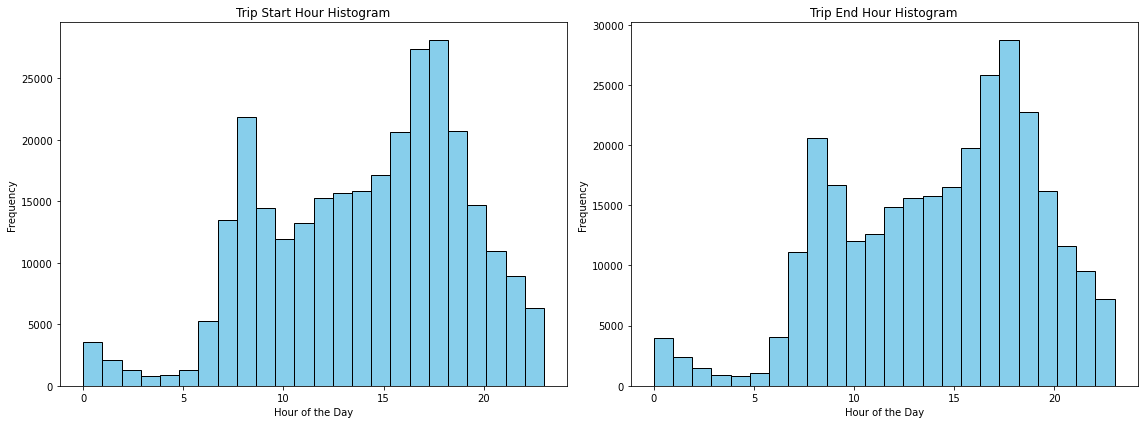

In [110]:
# Convert "Start Date" to datetime
clustered_all['Start Date'] = pd.to_datetime(clustered_all['Start Date'], format="%d/%m/%Y %H:%M")

# Extract the hour of the day
clustered_all['Start Hour'] = clustered_all['Start Date'].dt.hour

# Convert "End Date" to datetime
clustered_all['End Date'] = pd.to_datetime(clustered_all['End Date'], format="%d/%m/%Y %H:%M")

# Extract the hour of the day for end times
clustered_all['End Hour'] = clustered_all['End Date'].dt.hour

# Create a figure with two subplots in the same row
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Create a histogram of trip start hours
axs[0].hist(clustered_all['Start Hour'], bins=24, color='skyblue', edgecolor='black')
axs[0].set_title('Trip Start Hour Histogram')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Frequency')

# Create a histogram of trip end hours
axs[1].hist(clustered_all['End Hour'], bins=24, color='skyblue', edgecolor='black')
axs[1].set_title('Trip End Hour Histogram')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the combined plot
plt.show()


In [111]:
# Save the first plot as a PNG file in the 'img' folder one level up
axs[0].get_figure().savefig('../img/trip_start_hour_histogram.png')

# Save the second plot as a PNG file in the 'img' folder one level up
axs[1].get_figure().savefig('../img/trip_end_hour_histogram.png')

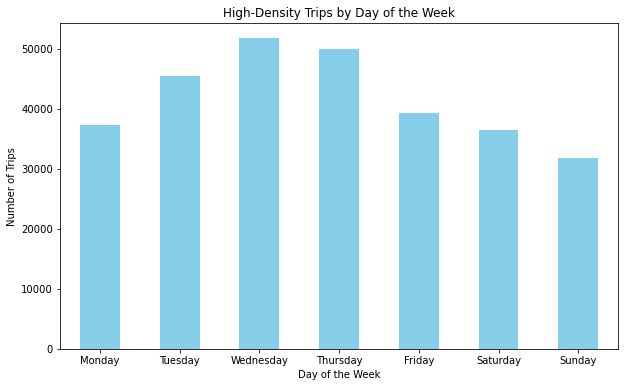

In [112]:
clustered_all['Day of Week'] = clustered_all['Start Date'].dt.day_name()

# Define the order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count the number of trips for each day of the week
day_counts = clustered_all['Day of Week'].value_counts()

# Create a histogram with custom x-tick labels
plt.figure(figsize=(10, 6))
day_counts.loc[days_order].plot(kind='bar', color='skyblue')
plt.title('High-Density Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

In [113]:
# Save the plot as a PNG file in the 'img' folder one level up
plt.savefig('../img/high_density_trips_by_day.png')

<Figure size 432x288 with 0 Axes>

In [114]:
# 根据Duration Gap生成新列'Trip Purpose'
clustered_all['Trip Purpose'] = clustered_all['Duration Gap'].apply(lambda x: 0 if x > 25 else 1)

# 显示部分数据以验证结果
clustered_all[['Duration Gap', 'Trip Purpose']].head()

,Duration Gap,Trip Purpose
0,12.898778,1
1,-3.045627,1
2,-17.044224,1
3,21.402140,1
4,7.212013,1


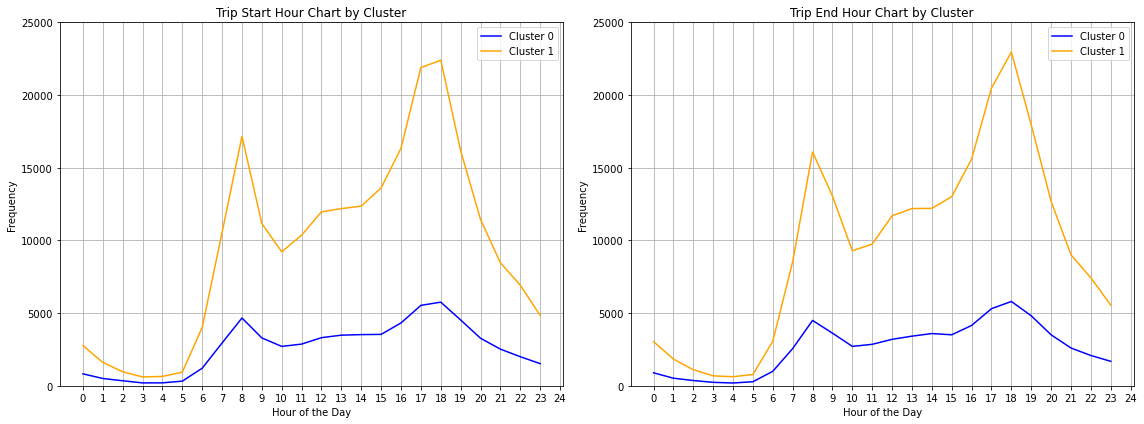

In [115]:
# 分别计算cluster为0和1时，每个小时的行程出发次数 Calculate the number of trip starts per hour when cluster is 0 and 1
hour_counts_0 = clustered_all[clustered_all['Trip Purpose'] == 0]['Start Hour'].value_counts().sort_index()
hour_counts_1 = clustered_all[clustered_all['Trip Purpose'] == 1]['Start Hour'].value_counts().sort_index()

# 创建连续的面积堆叠图，分别显示两个cluster的数据
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 创建第一个子图
axs[0].plot(hour_counts_0.index, hour_counts_0.values, color='blue', alpha=1.0, label='Cluster 0')
axs[0].plot(hour_counts_1.index, hour_counts_1.values, color='orange', alpha=1.0, label='Cluster 1')
axs[0].set_title('Trip Start Hour Chart by Cluster')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0, 25000)
axs[0].set_xticks(range(0, 25))
axs[0].legend()
axs[0].grid(True)


# 分别计算cluster为0和1时，每个小时的行程结束次数 Calculate the number of trip ends per hour when cluster is 0 and 1
end_hour_counts_0 = clustered_all[clustered_all['Trip Purpose'] == 0]['End Hour'].value_counts().sort_index()
end_hour_counts_1 = clustered_all[clustered_all['Trip Purpose'] == 1]['End Hour'].value_counts().sort_index()

# 创建第二个子图
axs[1].plot(end_hour_counts_0.index, end_hour_counts_0.values, color='blue', alpha=1.0, label='Cluster 0')
axs[1].plot(end_hour_counts_1.index, end_hour_counts_1.values, color='orange', alpha=1.0, label='Cluster 1')
axs[1].set_title('Trip End Hour Chart by Cluster')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 25000)
axs[1].set_xticks(range(0, 25))
axs[1].legend()
axs[1].grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

In [116]:
# Save the first plot as a PNG file in the 'img' folder one level up
axs[0].get_figure().savefig('../img/Clustered_start_hour_trip.png')

# Save the second plot as a PNG file in the 'img' folder one level up
axs[1].get_figure().savefig('../img/Clustered_end_hour_trip.png')

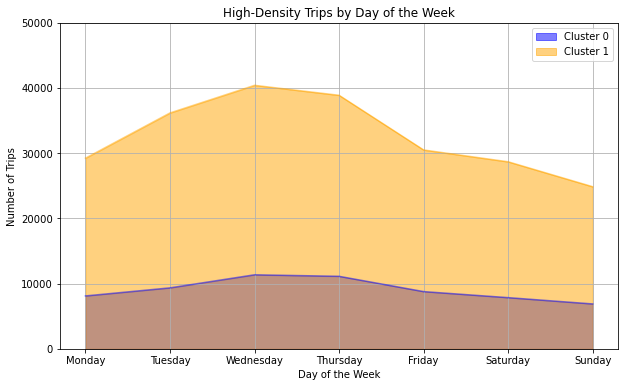

In [117]:

# 分别计算cluster为0和1时，每个小时的出行次数
day_counts_0 = clustered_all[clustered_all['Trip Purpose'] == 0]['Day of Week'].value_counts().sort_index()
day_counts_1 = clustered_all[clustered_all['Trip Purpose'] == 1]['Day of Week'].value_counts().sort_index()

# Define the order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a histogram with custom x-tick labels
plt.figure(figsize=(10, 6))
day_counts_0.loc[days_order].plot(kind='area', color='blue', alpha=0.5, label='Cluster 0')
day_counts_1.loc[days_order].plot(kind='area', color='orange', alpha=0.5, label='Cluster 1')
plt.title('High-Density Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.ylim(0, 50000) 
plt.xticks(rotation=0)

plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Save the plot as a PNG file in the 'img' folder one level up
plt.savefig('../img/high_density_trips_by_week.png')

<Figure size 432x288 with 0 Axes>

In [118]:
clustered_all.to_csv('clustered_all.csv', index=False)

## Accumulate Spatial points for each Cluster

In [119]:
clustered_all= pd.read_csv('clustered_all.csv')
clustered_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292032 entries, 0 to 292031
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Rental Id                       292032 non-null  int64  
 1   Actual Duration                 292032 non-null  float64
 2   Bike Id                         292032 non-null  int64  
 3   End Date                        292032 non-null  object 
 4   EndStation Id                   292032 non-null  int64  
 5   EndStation Name                 292032 non-null  object 
 6   Start Date                      292032 non-null  object 
 7   StartStation Id                 292032 non-null  int64  
 8   StartStation Name               292032 non-null  object 
 9   ObjectID                        292032 non-null  float64
 10  Name                            292032 non-null  object 
 11  Destinat_1                      292032 non-null  float64
 12  Shortest_Distanc

In [120]:
cluster_0 = clustered_all[clustered_all['Trip Purpose'] == 0]
cluster_1 = clustered_all[clustered_all['Trip Purpose'] == 1]

In [122]:
bike_trips = clustered_all[['StartStation Id', 'EndStation Id']]

In [65]:
bike_trips0 = cluster_0[['StartStation Id', 'EndStation Id']]
bike_trips1 = cluster_1[['StartStation Id', 'EndStation Id']]
bike_trips1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228629 entries, 0 to 311467
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   StartStation Id  228629 non-null  int64
 1   EndStation Id    228629 non-null  int64
dtypes: int64(2)
memory usage: 5.2 MB


In [55]:
#url containing the locations of all Santander bike stops
bike_locations = pd.read_csv('../Santander_stations.csv')
bike_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        795 non-null    int64  
 1   name      795 non-null    object 
 2   lat       795 non-null    float64
 3   lon       795 non-null    float64
 4   capacity  795 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 31.2+ KB


### Accumulated trips at Destination  in June 2022 for cluster 0
#### plotting end point for cluster 0 geojson

In [74]:
# Group by 'EndStation Id' and count the occurrences
inbound_num0 = bike_trips0.groupby('EndStation Id').size().reset_index(name='inbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum0 = bike_trips0.merge(inbound_num0, on='EndStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
destination_data_sum0 = bike_data_sum0[['EndStation Id', 'inbound_counts']].drop_duplicates()

# Print the result
destination_data_sum0.head(2)

# Merge bike_locations with destination_sum based on 'EndStation Id'
destination_dataXY0 = destination_data_sum0.merge(bike_locations, left_on='EndStation Id', right_on='id', how='inner')

# Print the merged DataFrame
destination_dataXY0.describe()

,EndStation Id,inbound_counts,id,lat,lon,capacity
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,433.095238,154.253133,433.095238,51.505988,-0.130739,0.513784
std,224.688105,161.915089,224.688105,0.021065,0.059979,0.829231
min,1.000000,2.000000,1.000000,51.454753,-0.236770,0.000000
25%,244.500000,48.000000,244.500000,51.491059,-0.179612,0.000000
50%,469.000000,109.000000,469.000000,51.509303,-0.138231,0.000000
75%,625.500000,204.500000,625.500000,51.522496,-0.085740,1.000000
max,788.000000,1103.000000,788.000000,51.549369,-0.002275,5.000000


In [88]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(destination_dataXY0['lon'], destination_dataXY0['lat'])
geo_df = gpd.GeoDataFrame(destination_dataXY0, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/end_points0.geojson", driver="GeoJSON")

end_points0 = geo_df
end_points0.head()

,EndStation Id,inbound_counts,id,name,lat,lon,capacity,geometry
0,39,767,39,"Shoreditch High Street, Shoreditch",51.526378,-0.078131,3,POINT (533420.107 182579.821)
1,53,74,53,"Grafton Street, Mayfair",51.509992,-0.143495,2,POINT (528932.257 180640.623)
2,114,279,114,"Park Road (Baker Street), The Regent's Park",51.524517,-0.158964,1,POINT (527818.247 182228.756)
3,732,976,732,"Duke Street Hill, London Bridge",51.506304,-0.087263,2,POINT (532844.998 180331.001)
4,428,1103,428,"Exhibition Road, Knightsbridge",51.499917,-0.174554,0,POINT (526804.986 179465.996)


### Accumulated trips at destination station in June 2022 for cluster 1
#### plotting end point for cluster 1 geojson

In [73]:
# Group by 'EndStation Id' and count the occurrences
inbound_num1 = bike_trips1.groupby('EndStation Id').size().reset_index(name='inbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum1 = bike_trips1.merge(inbound_num1, on='EndStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
destination_data_sum1 = bike_data_sum1[['EndStation Id', 'inbound_counts']].drop_duplicates()

# Merge bike_locations with destination_sum based on 'EndStation Id'
destination_dataXY1 = destination_data_sum1.merge(bike_locations, left_on='EndStation Id', right_on='id', how='inner')

# Print the merged DataFrame
destination_dataXY1.describe()

,EndStation Id,inbound_counts,id,lat,lon,capacity
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,415.844298,487.910088,415.844298,51.506377,-0.129892,0.521930
std,225.398811,399.285646,225.398811,0.020497,0.058222,0.825128
min,1.000000,1.000000,1.000000,51.454753,-0.236770,0.000000
25%,224.500000,229.500000,224.500000,51.492475,-0.176305,0.000000
50%,435.500000,413.000000,435.500000,51.509414,-0.135908,0.000000
75%,610.250000,658.500000,610.250000,51.522142,-0.087555,1.000000
max,788.000000,3853.000000,788.000000,51.549369,-0.002275,5.000000


In [82]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(destination_dataXY1['lon'], destination_dataXY1['lat'])
geo_df = gpd.GeoDataFrame(destination_dataXY1, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/end_points1.geojson", driver="GeoJSON")

end_points1 = geo_df
end_points1.head()

,EndStation Id,inbound_counts,id,name,lat,lon,capacity,geometry
0,581,559,581,"New Cavendish Street, Marylebone",51.519167,-0.147983,0,POINT (528595.027 181652.995)
1,361,658,361,"Waterloo Station 2, Waterloo",51.503920,-0.113426,0,POINT (531036.189 180018.691)
2,71,1073,71,"Newgate Street , St. Paul's",51.515419,-0.098851,0,POINT (532014.507 181323.574)
3,153,1593,153,"Bayswater Road, Hyde Park",51.511933,-0.174411,2,POINT (526781.583 180802.471)
4,752,1033,752,"London Street, Paddington",51.515117,-0.173713,1,POINT (526821.197 181157.754)


### Accumulated trips at origin station in June 2022 for cluster 0
#### plotting start point for cluster 0 geojson

In [70]:
# Group by 'EndStation Id' and count the occurrences
outbound_num0 = bike_trips0.groupby('StartStation Id').size().reset_index(name='outbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum0 = bike_trips0.merge(outbound_num0, on='StartStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
origin_data_sum0 = bike_data_sum0[['StartStation Id', 'outbound_counts']].drop_duplicates()

# Print the result
origin_data_sum0.head(2)

# Merge bike_locations with destination_sum based on 'EndStation Id'
origin_dataXY0 = origin_data_sum0.merge(bike_locations, left_on='StartStation Id', right_on='id', how='inner')

# Print the merged DataFrame
origin_dataXY0.describe()

,StartStation Id,outbound_counts,id,lat,lon,capacity
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.00000
mean,437.795455,157.952020,437.795455,51.505940,-0.127673,0.50000
std,226.446766,141.864136,226.446766,0.021362,0.060137,0.81598
min,1.000000,2.000000,1.000000,51.454753,-0.236770,0.00000
25%,248.750000,55.000000,248.750000,51.492776,-0.175925,0.00000
50%,474.500000,114.500000,474.500000,51.509327,-0.134630,0.00000
75%,630.500000,219.000000,630.500000,51.521893,-0.083458,1.00000
max,789.000000,1073.000000,789.000000,51.549369,-0.002275,5.00000


In [84]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(origin_dataXY0['lon'], origin_dataXY0['lat'])
geo_df = gpd.GeoDataFrame(origin_dataXY0, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/start_points0.geojson", driver="GeoJSON")

start_points0 = geo_df
start_points0.head()

,StartStation Id,outbound_counts,id,name,lat,lon,capacity,geometry
0,263,281,263,"St. Mary Axe, Aldgate",51.514225,-0.080660,2,POINT (533280.117 181223.791)
1,219,278,219,"Bramham Gardens, Earl's Court",51.490164,-0.190394,0,POINT (525732.417 178354.081)
2,16,107,16,"Cartwright Gardens , Bloomsbury",51.526358,-0.125979,0,POINT (530101.107 182491.519)
3,374,154,374,"Waterloo Station 1, Waterloo",51.504028,-0.113864,0,POINT (531005.476 180029.941)
4,391,119,391,"Clifford Street, Mayfair",51.510662,-0.142346,1,POINT (529010.137 180717.122)


### Accumulated trips at origin station in June 2022 for cluster 1
#### plotting start point for cluster 1 geojson

In [77]:
# Group by 'EndStation Id' and count the occurrences
outbound_num1 = bike_trips1.groupby('StartStation Id').size().reset_index(name='outbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum1 = bike_trips1.merge(outbound_num1, on='StartStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
origin_data_sum1 = bike_data_sum1[['StartStation Id', 'outbound_counts']].drop_duplicates()

# Print the result
origin_data_sum1.head(2)

# Merge bike_locations with destination_sum based on 'EndStation Id'
origin_dataXY1 = origin_data_sum1.merge(bike_locations, left_on='StartStation Id', right_on='id', how='inner')

# Print the merged DataFrame
origin_dataXY1.describe()

,StartStation Id,outbound_counts,id,lat,lon,capacity
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,420.017391,488.163043,420.017391,51.506188,-0.127223,0.491304
std,226.531514,403.118640,226.531514,0.020673,0.058172,0.804353
min,1.000000,1.000000,1.000000,51.454753,-0.236770,0.000000
25%,230.500000,241.750000,230.500000,51.493175,-0.174658,0.000000
50%,440.500000,413.000000,440.500000,51.509413,-0.131588,0.000000
75%,615.750000,660.500000,615.750000,51.521755,-0.085777,1.000000
max,789.000000,4456.000000,789.000000,51.549369,-0.002275,5.000000


In [85]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(origin_dataXY1['lon'], origin_dataXY1['lat'])
geo_df = gpd.GeoDataFrame(origin_dataXY1, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/start_points1.geojson", driver="GeoJSON")

start_points1 = geo_df
start_points1.head()

,StartStation Id,outbound_counts,id,name,lat,lon,capacity,geometry
0,364,556,364,"Store Street, Bloomsbury",51.519572,-0.132140,0,POINT (529692.999 181725.968)
1,383,875,383,"Frith Street, Soho",51.513103,-0.131214,2,POINT (529775.647 181008.270)
2,400,684,400,"George Street, Marylebone",51.517703,-0.154106,0,POINT (528174.335 181479.459)
3,114,64,114,"Park Road (Baker Street), The Regent's Park",51.524517,-0.158964,1,POINT (527818.247 182228.756)
4,117,595,117,"Lollard Street, Vauxhall",51.492881,-0.114934,2,POINT (530963.167 178788.417)


### Accumulated trips at origin station in June 2022 for all trips
#### plotting all start points geojson

In [123]:
# Group by 'EndStation Id' and count the occurrences
outbound_num = bike_trips.groupby('StartStation Id').size().reset_index(name='outbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum = bike_trips.merge(outbound_num, on='StartStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
origin_data_sum = bike_data_sum[['StartStation Id', 'outbound_counts']].drop_duplicates()

# Print the result
origin_data_sum.head(2)

# Merge bike_locations with destination_sum based on 'EndStation Id'
origin_dataXY = origin_data_sum.merge(bike_locations, left_on='StartStation Id', right_on='id', how='inner')

# Print the merged DataFrame
origin_dataXY.describe()

,StartStation Id,outbound_counts,id,lat,lon,capacity
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,420.017391,624.139130,420.017391,51.506188,-0.127223,0.491304
std,226.531514,470.993279,226.531514,0.020673,0.058172,0.804353
min,1.000000,1.000000,1.000000,51.454753,-0.236770,0.000000
25%,230.500000,330.750000,230.500000,51.493175,-0.174658,0.000000
50%,440.500000,569.000000,440.500000,51.509413,-0.131588,0.000000
75%,615.750000,871.250000,615.750000,51.521755,-0.085777,1.000000
max,789.000000,4644.000000,789.000000,51.549369,-0.002275,5.000000


In [125]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(origin_dataXY['lon'], origin_dataXY['lat'])
geo_df = gpd.GeoDataFrame(origin_dataXY, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/start_pointsALL.geojson", driver="GeoJSON")

start_points = geo_df
start_points.head()

,StartStation Id,outbound_counts,id,name,lat,lon,capacity,geometry
0,364,638,364,"Store Street, Bloomsbury",51.519572,-0.132140,0,POINT (529692.999 181725.968)
1,383,901,383,"Frith Street, Soho",51.513103,-0.131214,2,POINT (529775.647 181008.270)
2,400,814,400,"George Street, Marylebone",51.517703,-0.154106,0,POINT (528174.335 181479.459)
3,114,64,114,"Park Road (Baker Street), The Regent's Park",51.524517,-0.158964,1,POINT (527818.247 182228.756)
4,117,648,117,"Lollard Street, Vauxhall",51.492881,-0.114934,2,POINT (530963.167 178788.417)


### Accumulated trips at destination station in June 2022 for all trips
#### plotting all end points geojson

In [129]:
# Group by 'EndStation Id' and count the occurrences
inbound_num = bike_trips.groupby('EndStation Id').size().reset_index(name='inbound_counts')

# Merge the counts with the original DataFrame
bike_data_sum = bike_trips.merge(inbound_num, on='EndStation Id')

# Keep only 'EndStation Id' and 'inbound_num' columns
destination_data_sum = bike_data_sum[['EndStation Id', 'inbound_counts']].drop_duplicates()

# Print the result
destination_data_sum.head(2)

# Merge bike_locations with destination_sum based on 'EndStation Id'
destination_dataXY = destination_data_sum.merge(bike_locations, left_on='EndStation Id', right_on='id', how='inner')

# Print the merged DataFrame
destination_dataXY.describe()

,EndStation Id,inbound_counts,id,lat,lon,capacity
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,415.844298,622.881579,415.844298,51.506377,-0.129892,0.521930
std,225.398811,493.831678,225.398811,0.020497,0.058222,0.825128
min,1.000000,1.000000,1.000000,51.454753,-0.236770,0.000000
25%,224.500000,305.250000,224.500000,51.492475,-0.176305,0.000000
50%,435.500000,554.500000,435.500000,51.509414,-0.135908,0.000000
75%,610.250000,832.500000,610.250000,51.522142,-0.087555,1.000000
max,788.000000,4865.000000,788.000000,51.549369,-0.002275,5.000000


In [130]:
# Create a GeoDataFrame using the latitude and longitude columns
geometry = gpd.points_from_xy(destination_dataXY['lon'], destination_dataXY['lat'])
geo_df = gpd.GeoDataFrame(destination_dataXY, geometry=geometry, crs="EPSG:4326")

# Convert to EPSG:27700
geo_df = geo_df.to_crs(epsg=27700)

# Save the GeoDataFrame to GeoJSON
geo_df.to_file("../GIS_file/end_pointsALL.geojson", driver="GeoJSON")

end_points = geo_df
end_points.head()

,EndStation Id,inbound_counts,id,name,lat,lon,capacity,geometry
0,581,711,581,"New Cavendish Street, Marylebone",51.519167,-0.147983,0,POINT (528595.027 181652.995)
1,361,721,361,"Waterloo Station 2, Waterloo",51.503920,-0.113426,0,POINT (531036.189 180018.691)
2,71,1308,71,"Newgate Street , St. Paul's",51.515419,-0.098851,0,POINT (532014.507 181323.574)
3,153,1723,153,"Bayswater Road, Hyde Park",51.511933,-0.174411,2,POINT (526781.583 180802.471)
4,752,1059,752,"London Street, Paddington",51.515117,-0.173713,1,POINT (526821.197 181157.754)


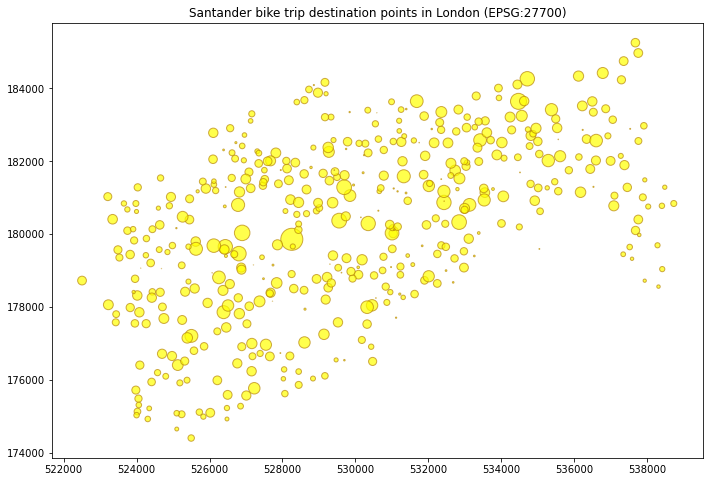

In [134]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))
#fig, ax = plt.plots(figsize=(12, 8))
# Plot the service area
#lsoa_gdf_27700.plot(ax=ax, color='lightgrey', edgecolor='none')

# Plot the station points with size based on log-scaled "inbike_locationsbound_counts"
end_points.plot(ax=ax, color='yellow', markersize=end_points['inbound_counts'] / 10, edgecolor='darkgoldenrod', alpha=0.7)

# Add title
ax.set_title('Santander bike trip destination points in London (EPSG:27700)')

# Show plot
plt.show()

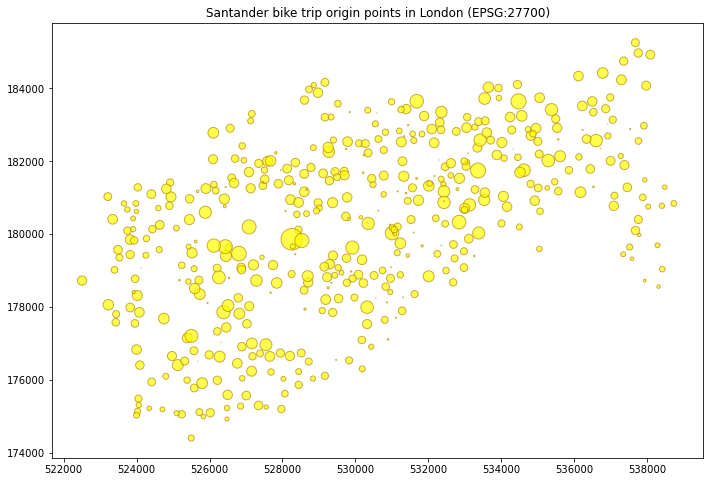

In [135]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))
#fig, ax = plt.plots(figsize=(12, 8))
# Plot the service area
#lsoa_gdf_27700.plot(ax=ax, color='lightgrey', edgecolor='none')

# Plot the station points with size based on log-scaled "inbike_locationsbound_counts"
start_points.plot(ax=ax, color='yellow', markersize=start_points['outbound_counts'] / 10, edgecolor='darkgoldenrod', alpha=0.7)

# Add title
ax.set_title('Santander bike trip origin points in London (EPSG:27700)')

# Show plot
plt.show()